In [5]:
import numpy as np
import bayes3d as b
from tqdm import tqdm
import jax
import jax.numpy as jnp
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
import matplotlib.pyplot as plt
def projection(x=0.1, n=1.0, f=50.0):
    return np.array([[n/x,    0,            0,              0],
                     [  0,  n/x,            0,              0],
                     [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                     [  0,    0,           -1,              0]]).astype(np.float32)
def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]]).astype(np.float32)

mvp = np.matmul(projection(x=0.4), translate(0, 0, 0.0)).astype(np.float32)
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)
jax_renderer = JaxRenderer(intrinsics)

import os
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

pos = jnp.array(m.vertices.astype(np.float32))
pos_idx = jnp.array(m.faces.astype(np.int32))

New Plugin


In [6]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7035/static/


In [7]:
def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)
xfm_points(jnp.zeros((10,3)), jnp.eye(4))

Array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [71]:
# pose = b.transform_from_pos(jnp.array([0.0, 0.0, -3.5])) @ b.distributions.vmf(jax.random.PRNGKey(10), 0.01)
# vertices_pose_transformed = vertices_homogenous @ pose.T
# vertices_projected = vertices_pose_transformed @ mvp.T
# rast_out, rast_out_db = jax_renderer.rasterize(vertices_projected[None,...], face_indices, jnp.array([intrinsics.height, intrinsics.width]))
# colors,_ = jax_renderer.interpolate(vertices_pose_transformed[:,2:3][None,...], rast_out, face_indices, rast_out_db, jnp.array([0]))
key = jax.random.PRNGKey(15)

def render_img(translation,quat):
    pose = b.transform_from_rot_and_pos(b.quaternion_to_rotation_matrix(quat), translation)

    final_mtx_proj = mvp @ pose

    posw = jnp.concatenate([pos, jnp.ones((*pos.shape[:-1],1))], axis=-1)
    pos_clip_ja = xfm_points(pos, final_mtx_proj)

    rast_out, rast_out_db = jax_renderer.rasterize(pos_clip_ja[None,...], pos_idx, jnp.array([intrinsics.height, intrinsics.width]))
    gb_pos,_ = jax_renderer.interpolate(posw[None,...], rast_out, pos_idx, rast_out_db, jnp.array([0,1,2,3]))
    mask = rast_out[..., -1] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = xfm_points(gb_pos, pose)
    depth = depth.reshape(shape_keep)[..., 2] * -1
    return depth, mask

def loss(translation, quat, colors_gt, mask):
    colors, _ = render_img(translation,quat)
    return jnp.mean(jnp.abs(colors_gt - colors) * mask)

grad_func = jax.jit(jax.value_and_grad(loss, argnums=(0,1)))

(1, 200, 200)
(1, 200, 200)


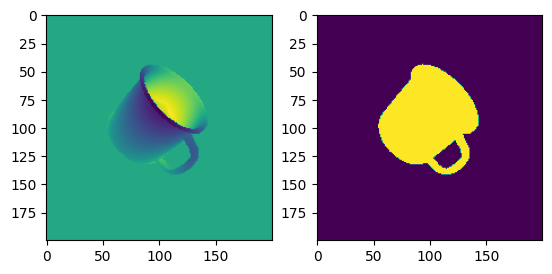

In [73]:
key = jax.random.split(key, 2)[0]
translation, quat = jnp.array([0.0, 0.0, -3.2]), jax.random.uniform(key, shape=(4,))
colors_gt, gt_mask = render_img(translation,quat)
print(colors_gt.shape)
print(gt_mask.shape)
fig,ax = plt.subplots(1,2)
ax[0].imshow(colors_gt[0,...])
ax[1].imshow(gt_mask[0])

0.04856819


0.044676996767520905:   0%|          | 0/2000 [00:00<?, ?it/s]

0.0009222371154464781: 100%|██████████| 2000/2000 [00:04<00:00, 422.61it/s] 


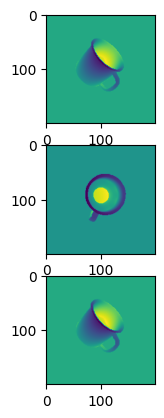

In [76]:
key = jax.random.split(key, 2)[0]
translation, quat = jnp.array([0.0, 0.0, -3.4]), jax.random.uniform(key, shape=(4,))
loss, (pos_grad, quat_grad) = grad_func(translation, quat, colors_gt, gt_mask)
print(loss)
begining_img,_ = render_img(translation,quat)
pbar = tqdm(range(2000))
for _ in pbar:
    loss, (pos_grad, quat_grad) = grad_func(translation, quat, colors_gt, gt_mask)
    pbar.set_description(f"{loss}")
    translation = translation - 0.01 * pos_grad
    quat = quat - 1.0 * quat_grad

img,_ = render_img(translation,quat)
fig,ax = plt.subplots(3)
ax[0].imshow(colors_gt[0,...])
ax[1].imshow(begining_img[0,...])
ax[2].imshow(img[0,...])